In [5]:
import glob,os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [6]:
file = './A549_chr21-28-30Mb.csv'
lines = [ln[:-1].split(',') for ln in open(file,'r')]

# keep only data entries and reorganize the data
keep = np.array([len(ln) for ln in lines]) > 1
data = np.array([line for line, kp in zip(lines, keep) if kp][1:], dtype=float)
chromosomes = data[:,0]
nchr = len(np.unique(chromosomes))
zxys = data[:,2:].reshape([nchr,-1,3])

print(zxys.shape)

(3941, 65, 3)


In [14]:
zxys

array([[[  1797.,  73152.,   6517.],
        [  1709.,  73113.,   6643.],
        [  1494.,  73488.,   6191.],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[  1649.,  92919.,  44636.],
        [  1588.,  92918.,  44627.],
        [  1711.,  93010.,  44659.],
        ...,
        [  1170.,  92408.,  44565.],
        [  1372.,  92481.,  44617.],
        [  1462.,  92254.,  44524.]],

       [[  2635.,  96389.,   4902.],
        [  2234.,  96483.,   5137.],
        [  2295.,  96348.,   5232.],
        ...,
        [  2648.,  96435.,   5223.],
        [  2728.,  96413.,   5267.],
        [  2708.,  96394.,   5348.]],

       ...,

       [[  1385.,  20194.,  59145.],
        [  1318.,  20171.,  58930.],
        [  1395.,  20362.,  58777.],
        ...,
        [    nan,     nan,     nan],
        [   964.,  20126.,  58925.],
        [    nan,     nan,     nan]],

       [[  1078.,  67031.,  15888.],
  

In [8]:
from scipy.spatial.distance import pdist, squareform
# Build a 3D array: [num_samples, n_points, n_points]
distance_mats = np.array([squareform(pdist(coords)) for coords in zxys])
med_mat = np.nanmedian(distance_mats, axis=0)

In [13]:
med_mat

array([[  0.        , 227.74654051, 289.34840281, ..., 761.8018115 ,
        737.85499931, 739.10038798],
       [227.74654051,   0.        , 207.63670196, ..., 714.84613729,
        712.4450856 , 707.8043515 ],
       [289.34840281, 207.63670196,   0.        , ..., 724.61921034,
        711.35570794, 692.1163197 ],
       ...,
       [761.8018115 , 714.84613729, 724.61921034, ...,   0.        ,
        220.99095004, 307.65634238],
       [737.85499931, 712.4450856 , 711.35570794, ..., 220.99095004,
          0.        , 258.42793967],
       [739.10038798, 707.8043515 , 692.1163197 , ..., 307.65634238,
        258.42793967,   0.        ]])

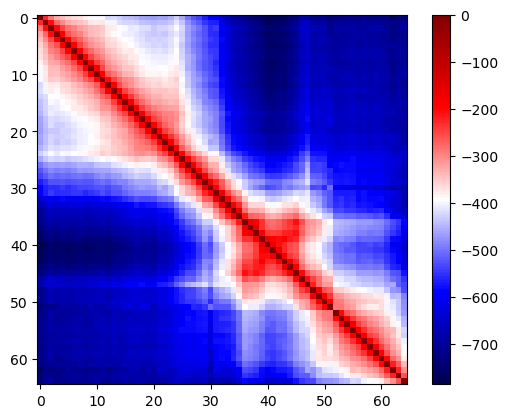

In [9]:
#Plot the median distance map
plt.figure()
plt.imshow(-med_mat,interpolation='nearest',cmap='seismic')
plt.colorbar()
plt.show()

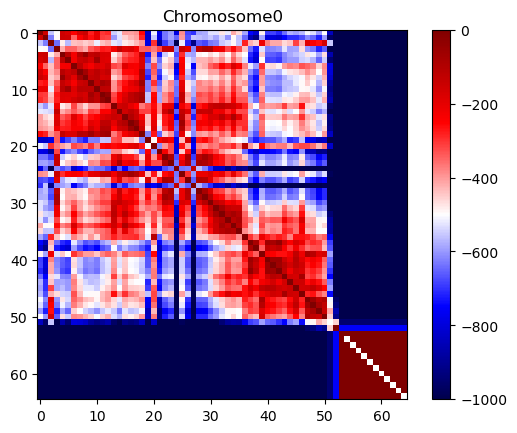

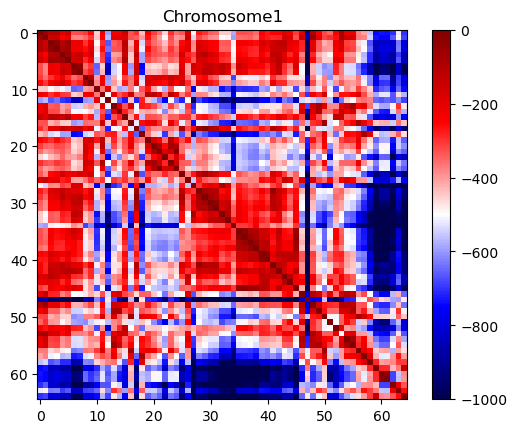

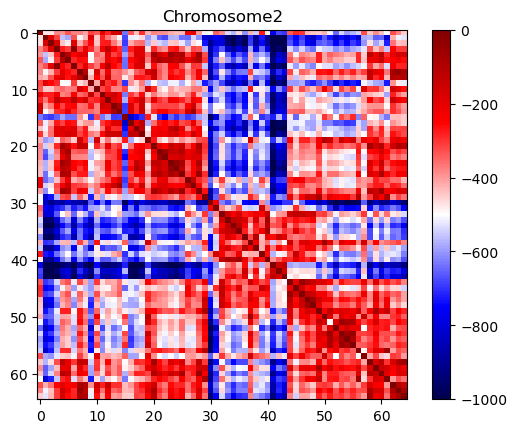

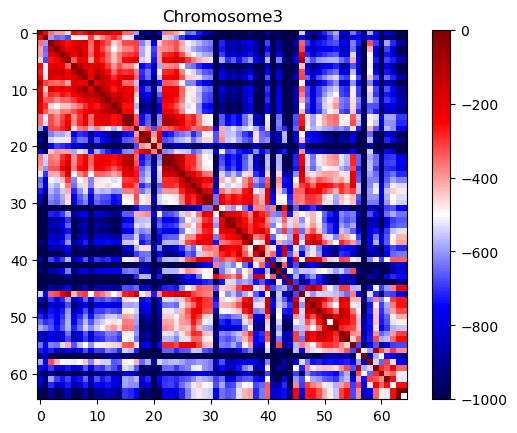

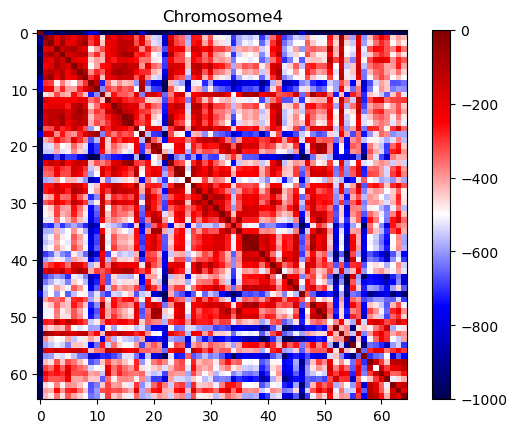

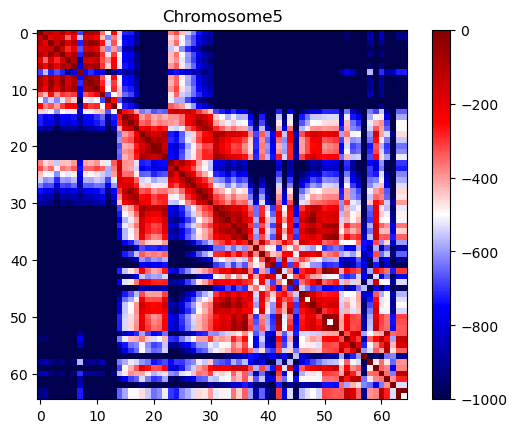

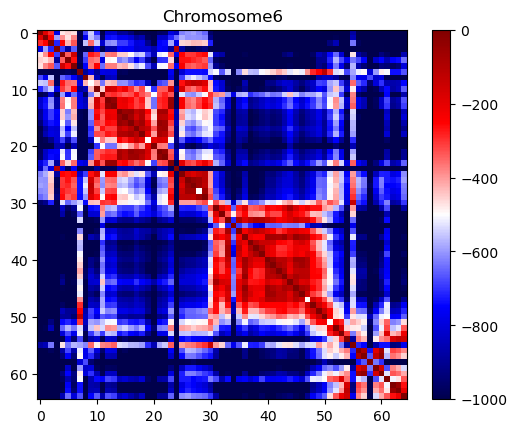

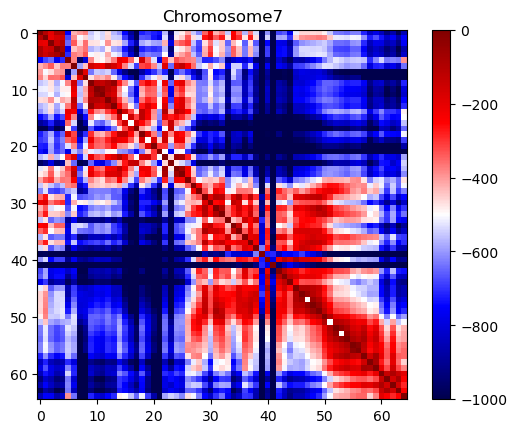

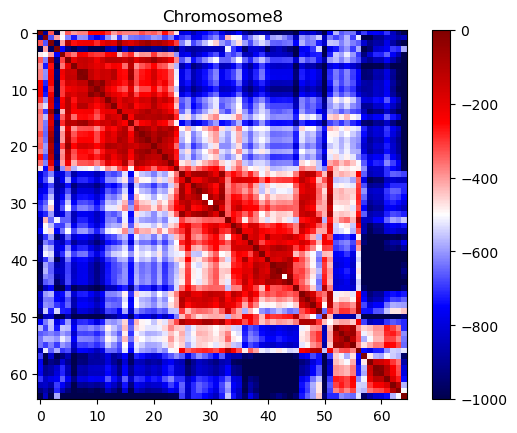

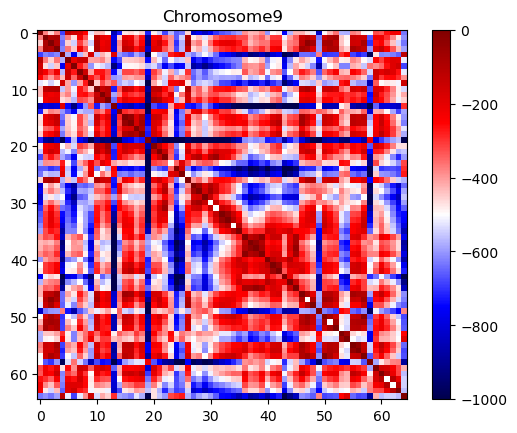

In [12]:
def interp1dnan(A):
    A_ = np.array(A)
    missing = np.isnan(A_)
    nonmissing = ~missing
    xp = np.where(nonmissing)[0]
    fp = A_[nonmissing]
    x  = np.where(missing)[0]
    A_[missing] = np.interp(x, xp, fp)
    return A_
def plot_map(zxy, interpolate=True):
    """
    We can interpolate across positions we do not have data (too dim to reliably fit).
    We mark those positions as white on the diagonal.
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array([interp1dnan(a) for a in zxy.T]).T
        bad = np.where(np.isnan(zxy[:,0]))[0]
    mat_ = squareform(pdist(zxy_))
    mat_[bad,bad] = np.nan
    plt.imshow(-mat_, interpolation='nearest', cmap='seismic', vmin=-1000, vmax=0)
    
for i in range(10):
    plt.figure()
    plt.title('Chromosome'+str(i))
    
    plot_map(zxys[i])
    
    plt.colorbar()
    plt.show()